## Numerical Integration to Calculate Free Energy

In [291]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.double)
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import pickle
import scipy.integrate as integrate
import os

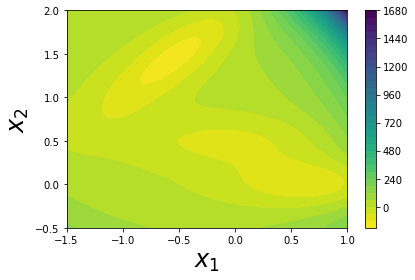

In [293]:
def compute_Muller_potential(beta, x):
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)    
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))
    
    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))
    
    U = 0    
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))

    return beta*U

def generate_grid(x1_min, x1_max, x2_min, x2_max, ndim1, ndim2):
    x1 = torch.linspace(x1_min, x1_max, steps=ndim1)
    x2 = torch.linspace(x2_min, x2_max, steps=ndim2)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2)
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x
    
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
ndim = 100

x = generate_grid(x1_min, x1_max, x2_min, x2_max, ndim, ndim)
U = compute_Muller_potential(1, x)
U = U.reshape(ndim, ndim)
U = U.T

fig = plt.figure(0)
fig.clf()
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
#plt.contourf(U, levels = 30, cmap = cm.viridis_r)

plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.tight_layout()

In [294]:
alpha = 0.05

with open("./output/range.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
x1_min, x1_max = data['x1_min'], data['x1_max']
x2_min, x2_max = data['x2_min'], data['x2_max']

num_reps = 10
alphas = torch.linspace(0.0, alpha, num_reps)

num_steps = 510000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
energy = compute_Muller_potential(1.0, x)

for k in range(num_steps):
    if (k + 1) % 500 == 0:
        print("idx of steps: {}".format(k))
        
    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.3
    x_p = x + delta_x
    energy_p = compute_Muller_potential(1.0, x_p)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)
    
    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]    
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)    
    
    ## exchange
    if k % 10 == 0:
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item():
                tmp = x[i]
                x[i] = x[i-1]
                x[i-1] = tmp

                tmp = energy[i]
                energy[i] = energy[i-1]
                energy[i-1] = tmp
        if k >= 10000:
            x_record.append(x.clone().numpy())

x_record = np.array(x_record)

idx of steps: 49999
idx of steps: 99999
idx of steps: 149999
idx of steps: 199999
idx of steps: 249999
idx of steps: 299999
idx of steps: 349999
idx of steps: 399999
idx of steps: 449999
idx of steps: 499999


In [278]:
def compute_Muller_potential_point(x, y):
    """
    Computes the Muller potential at a point r = (x, y).
    """
    A = (-200., -100., -170., 15.)
    a = (-1, -1, -6.5, 0.7)
    b = (0., 0., 11., 0.6) 
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)

    result = 0
    for k in range(4):
        result += A[k]*np.exp(a[k]*(x-x0[k])**2 + b[k]*(x-x0[k])*(y-y0[k])+ c[k]*(y-y0[k])**2)
    return result 

In [301]:
partition_function = dict()
beta = 0.025
def p_x_y(x, y, beta = 0.025):
    """
    Returns the probability density at a point (x, y).
    """
    U_r = compute_Muller_potential_point(x, y)
    try:
        q = partition_function[beta]
    except:
        q = integrate.nquad(lambda x, y: np.exp(-beta*compute_Muller_potential_point(x , y)), 
        [[-11, 11], [-11, 11]])
        partition_function[beta] = q
    
    return np.exp(-beta*U_r)/q[0]

basin1_q = integrate.nquad(p_x_y, [[-1.5, 0], [0.55, 2]])
basin2_q = integrate.nquad(p_x_y, [[-0.8, 1], [-0.5, 0.8]])
print(integrate.nquad(p_x_y, [[-11, 11], [-11, 11]]))

(0.9999999998199389, 1.485403849056759e-08)


In [300]:
print(np.log(basin1_q[0]/basin2_q[0]))
print(np.log(basin2_q[0]/basin1_q[0]))
print(-(1/beta)*np.log(basin1_q[0]/basin2_q[0]))

0.468786982982445
-0.468786982982445
-18.7514793192978


# Compute Muller Potential by Direct Counting

In [296]:
"""
d = os.path.abspath('')

with open('x_record_alpha_{:.3f}.pkl'.format(beta), 'rb') as file_handle:
    data = pickle.load(file_handle)

xp = data['x_record'][:, -1, :]
"""

"\nd = os.path.abspath('')\n\nwith open('x_record_alpha_{:.3f}.pkl'.format(beta), 'rb') as file_handle:\n    data = pickle.load(file_handle)\n\nxp = data['x_record'][:, -1, :]\n"

In [297]:
xp = x_record[:, -1, :]
print(xp)

[[-0.88227903  1.21033082]
 [ 0.44412967  0.29733239]
 [-1.06144964  0.57728306]
 ...
 [-0.62770639  1.6909242 ]
 [-0.63752469  1.36704305]
 [-0.63752469  1.36704305]]


In [299]:
basin1_N = 0
basin2_N = 0

for (x, y) in xp:
    if (-1.5 < x < 0) and (0.55 < y < 2):
        basin1_N += 1
    if (-0.8 < x < 1) and (-0.5 < y < 0.8):
        basin2_N += 1

print(np.log(basin1_N/basin2_N))
print(np.log(basin2_N/basin1_N))
print(-(1/beta)*np.log(basin1_N/basin2_N))
print(beta)

0.8496103056712438
-0.8496103056712438
-33.984412226849756
0.025
